In [1]:
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
#import utm
import datetime as dt
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [2]:
zoneNum = 'S'
zone = 11
useModeledDatapoints = True
dataPoints = [
#     easting, northing, alt, RSSI
    [373634, 4930271, 30, 60],
    [373624, 4930281, 30, 50],
    [373634, 4930291, 30, 40],
    [373654, 4930271, 30, 30]
]
txLocation = [373636, 4930279, 0]
P_tx_real = 60
n_real = 2.1

The function `distanceToReceivePower` calculates the the received signal power given `pingVector` which denotes the position of the drone at the measurement and `paramVec` which denotes the signal model parameters $x_tx$, $y_tx$, $P_{tx}$, and $n$.

This is based on the following model:

$$P_{tx} - P_{{rx}_i} + \epsilon_i= 10n \log_{10}\left({\left|\vec{l_{tx}} - \vec{l_{{rx}_i}}\right|}\right) + C$$

where

$\vec{l_{tx}} = \begin{bmatrix}l_{{tx}_x} \\ l_{{tx}_y} \\ l_{{tx}_z}\end{bmatrix}$ is the transmitter location in meters

$\vec{l_{{rx}_i}} = \begin{bmatrix}l_{{rx}_{x_i}} \\ l_{{rx}_{y_i}} \\ l_{{rx}_{z_i}}\end{bmatrix}$ is the $i^{th}$measurement location in meters

$P_{tx}$ is the transmit power in dB

$P_{{rx}_i}$ is the $i^{th}$ measurement's received power in dB

$n$ is the path loss exponent

$C$ is the inherent system losses in dB, which is assumed to be zero

$\epsilon_i$ is accumulated errors

Thus:

$$X_i = pingVector = \begin{bmatrix} l_{{rx}_{x_i}} \\ l_{{rx}_{y_i}} \\ l_{{rx}_{z_i}} \\ P_{{rx}_i}\end{bmatrix} \in \mathbb{R}^4$$
$$A = paramVector = \begin{bmatrix} l_{{tx}_x} \\ l_{{tx}_y} \\ P_{tx} \\ n\end{bmatrix} \in \mathbb{R}^4$$
$$P_{{rx}_i} = P_{tx} - 10 n \log_{10}\left(\left|\vec{l_{tx}} - \vec{l_{{rx}_i}}\right|\right) + \epsilon_i$$

In [3]:
def distanceToReceivePower(pingVector, paramVec):
    l_rx = np.array(pingVector[0:3])
    l_tx = np.array([paramVec[0], paramVec[1], 0])
    P_tx = paramVec[2]
    n = paramVec[3]
    
    d = np.linalg.norm(l_rx - l_tx)
    
    if d < 0.01:
        d = 0.01
    
    P_rx = P_tx - 10 * n * np.log10(d)
    return P_rx

$$\widehat{d} = \left|\widehat{\vec{l_{tx}}} - \vec{l_{{rx}_i}}\right| = 10 ^ {\frac{P_{tx} - P_{{rx}_i}}{10n}}$$

In [4]:
def RSSItoDistance(P_rx, P_tx, n, alt=0):
    dist = 10 ** ((P_tx - P_rx) / (10 * n))
    if alt != 0:
        dist = np.sqrt(dist ** 2 - alt ** 2)
    return dist

The below function calculates the residuals vector:

$$\epsilon_i = P_{{rx}_i} - \widehat{P_{{rx}_i}}$$

In [5]:
def residuals(paramVec, data):
    result = np.zeros(len(data))
    
    for i in range(len(data)):
        pingVector = data[i,:]
        result[i] = pingVector[3] - distanceToReceivePower(pingVector, paramVec)
    
    return result

We assume the additive error to the received power is normally distributed.

$$ \epsilon_i \sim \mathcal{N}\left(0, \sigma\left[L\right]\right) = \sigma\left[L\right]\mathcal{Z}$$

$$d = \left|\vec{l_{tx}} - \vec{l_{rx}}\right| = 10^{\frac{P_{tx} - P_{{rx}_i} + \epsilon_i}{10n}}$$

$$d = \exp\left(\log_{10}\left(e\right) \frac{P_{tx} - P_{{rx}_i}}{10n} + \log_{10}\left(e\right)\frac{\epsilon_i}{10n}\right)$$

$$d \sim Lognormal\left(\mu =\log_{10}\left(e\right)\frac{\left(P_{tx} - P_{{rx}_i}\right)}{10n}, \sigma = \log_{10}\left(e\right)\frac{\sigma\left[L\right]}{10n}\right)$$

The below function calculates the probability of the transmitter being located at $\vec{tx}$ given the drone's location at $\vec{dx}$ and the signal model parameters $n$, $P_{rx}$, and $P_{tx}$.  This currently doesn't work!

In [6]:
def p_x(tx, dx, n, P_rx, P_tx, L_std):
    pdfMean = np.log10(np.e) * (P_tx - P_rx) / (10 * n)
    pdfStd = np.log10(np.e) * L_std / (10 * n)
    distance = np.linalg.norm(dx - tx)
    
    x = distance
    scale = np.exp(pdfMean)
    s = pdfStd
    loc = 0
    p = ss.lognorm.pdf(x = x, s = s, loc = loc, scale = scale)
    
#     p = P.pdf(distance)
#     print("Mean: %f, std: %f, PDF: %s, dist: %f, p: %f" % (pdfMean, pdfStd, P, distance, p))
    return p

The below function calculates the probability of the transmitter being located at tx given the drone's location at dx, the signal model parameters n, P\_rx, P\_tx, and the standard variation of distance errors D\_std.  This asumes that the source of error is a normal distribution that is additive to the calculated distances.

In [8]:
def p_d(tx, dx, n, P_rx, P_tx, D_std):
    modeledDistance = RSSItoDistance(P_rx, P_tx, n)
    return ss.norm.pdf(np.linalg.norm(dx - tx), loc=modeledDistance, scale=D_std)
    

In [9]:
if useModeledDatapoints:
    goldenParams = np.array([txLocation[0], txLocation[1], P_tx_real, n_real])
    for dataPoint in dataPoints:
        dataPoint[3] = distanceToReceivePower(np.array(dataPoint), goldenParams)
dataPoints

[[373634, 4930271, 30, 28.64830874826187],
 [373624, 4930281, 30, 28.286206532199067],
 [373634, 4930291, 30, 28.286206532199067],
 [373654, 4930271, 30, 27.34588343825017]]

In [10]:
pings = np.array(dataPoints)
x_tx_0 = np.mean(pings[:,0])
y_tx_0 = np.mean(pings[:,1])
P_tx_0 = np.max(pings[:,3])
n_0 = 2

initialParams = np.array([x_tx_0, y_tx_0, P_tx_0, n_0])
res_x = so.least_squares(residuals, initialParams, bounds=([0, 167000, -np.inf, 2], [833000, 10000000, np.inf, 2.1]), args=[pings])

estParams = res_x.x
estSuccess = res_x.success
l_tx = estParams[0:2]
P_tx = estParams[2]
n_tx = estParams[3]

In [11]:
distances = np.linalg.norm(pings[:,0:3] - np.array([l_tx[0], l_tx[1], 0]), axis=1)
calculatedDistances = RSSItoDistance(pings[:,3], P_tx, n_tx)

distanceErrors = calculatedDistances - distances
stdDistances = np.std(distanceErrors)

In [12]:
margin = 10
tiffXSize = int(2 * np.max(calculatedDistances) + margin)
tiffYSize = int(2 * np.max(calculatedDistances) + margin)
pixelSize = 1
minY = l_tx[1] - np.max(distances) - margin / 2
refY = l_tx[1] + np.max(distances) + margin / 2
refX = l_tx[0] - np.max(distances) - margin / 2
maxX = l_tx[0] + np.max(distances) + margin / 2

In [13]:
lookup = {}

lookup[4.0] = [    0.00003,    0.00003,    0.00003,    0.00003,    0.00003,    0.00003,    0.00002,    0.00002,    0.00002,    0.00002]
lookup[3.9] = [    0.00005,    0.00005,    0.00004,    0.00004,    0.00004,    0.00004,    0.00004,    0.00004,    0.00003,    0.00003]
lookup[3.8] = [    0.00007,    0.00007,    0.00007,    0.00006,    0.00006,    0.00006,    0.00006,    0.00005,    0.00005,    0.00005]
lookup[3.7] = [    0.00011,    0.00010,    0.00010,    0.00010,    0.00009,    0.00009,    0.00008,    0.00008,    0.00008,    0.00008]
lookup[3.6] = [    0.00016,    0.00015,    0.00015,    0.00014,    0.00014,    0.00013,    0.00013,    0.00012,    0.00012,    0.00011]
lookup[3.5] = [    0.00023,    0.00022,    0.00022,    0.00021,    0.00020,    0.00019,    0.00019,    0.00018,    0.00017,    0.00017]
lookup[3.4] = [    0.00034,    0.00032,    0.00031,    0.00030,    0.00029,    0.00028,    0.00027,    0.00026,    0.00025,    0.00024]
lookup[3.3] = [    0.00048,    0.00047,    0.00045,    0.00043,    0.00042,    0.00040,    0.00039,    0.00038,    0.00036,    0.00035]
lookup[3.2] = [    0.00069,    0.00066,    0.00064,    0.00062,    0.00060,    0.00058,    0.00056,    0.00054,    0.00052,    0.00050]
lookup[3.1] = [    0.00097,    0.00094,    0.00090,    0.00087,    0.00084,    0.00082,    0.00079,    0.00076,    0.00074,    0.00071]
lookup[3.0] = [    0.00135,    0.00131,    0.00126,    0.00122,    0.00118,    0.00114,    0.00111,    0.00107,    0.00104,    0.00100]
lookup[2.9] = [    0.00187,    0.00181,    0.00175,    0.00169,    0.00164,    0.00159,    0.00154,    0.00149,    0.00144,    0.00139]
lookup[2.8] = [    0.00256,    0.00248,    0.00240,    0.00233,    0.00226,    0.00219,    0.00212,    0.00205,    0.00199,    0.00193]
lookup[2.7] = [    0.00347,    0.00336,    0.00326,    0.00317,    0.00307,    0.00298,    0.00289,    0.00280,    0.00272,    0.00264]
lookup[2.6] = [    0.00466,    0.00453,    0.00440,    0.00427,    0.00415,    0.00402,    0.00391,    0.00379,    0.00368,    0.00357]
lookup[2.5] = [    0.00621,    0.00604,    0.00587,    0.00570,    0.00554,    0.00539,    0.00523,    0.00508,    0.00494,    0.00480]
lookup[2.4] = [    0.00820,    0.00798,    0.00776,    0.00755,    0.00734,    0.00714,    0.00695,    0.00676,    0.00657,    0.00639]
lookup[2.3] = [    0.01072,    0.01044,    0.01017,    0.00990,    0.00964,    0.00939,    0.00914,    0.00889,    0.00866,    0.00842]
lookup[2.2] = [    0.01390,    0.01355,    0.01321,    0.01287,    0.01255,    0.01222,    0.01191,    0.01160,    0.01130,    0.01101]
lookup[2.1] = [    0.01786,    0.01743,    0.01700,    0.01659,    0.01618,    0.01578,    0.01539,    0.01500,    0.01463,    0.01426]
lookup[2.0] = [    0.02275,    0.02222,    0.02169,    0.02118,    0.02068,    0.02018,    0.01970,    0.01923,    0.01876,    0.01831]
lookup[1.9] = [    0.02872,    0.02807,    0.02743,    0.02680,    0.02619,    0.02559,    0.02500,    0.02442,    0.02385,    0.02330]
lookup[1.8] = [    0.03593,    0.03515,    0.03438,    0.03362,    0.03288,    0.03216,    0.03144,    0.03074,    0.03005,    0.02938]
lookup[1.7] = [    0.04457,    0.04363,    0.04272,    0.04182,    0.04093,    0.04006,    0.03920,    0.03836,    0.03754,    0.03673]
lookup[1.6] = [    0.05480,    0.05370,    0.05262,    0.05155,    0.05050,    0.04947,    0.04846,    0.04746,    0.04648,    0.04551]
lookup[1.5] = [    0.06681,    0.06552,    0.06426,    0.06301,    0.06178,    0.06057,    0.05938,    0.05821,    0.05705,    0.05592]
lookup[1.4] = [    0.08076,    0.07927,    0.07780,    0.07636,    0.07493,    0.07353,    0.07215,    0.07078,    0.06944,    0.06811]
lookup[1.3] = [    0.09680,    0.09510,    0.09342,    0.09176,    0.09012,    0.08851,    0.08692,    0.08534,    0.08379,    0.08226]
lookup[1.2] = [    0.11507,    0.11314,    0.11123,    0.10935,    0.10749,    0.10565,    0.10383,    0.10204,    0.10027,    0.09853]
lookup[1.1] = [    0.13567,    0.13350,    0.13136,    0.12924,    0.12714,    0.12507,    0.12302,    0.12100,    0.11900,    0.11702]
lookup[1.0] = [    0.15866,    0.15625,    0.15386,    0.15151,    0.14917,    0.14686,    0.14457,    0.14231,    0.14007,    0.13786]
lookup[0.9] = [    0.18406,    0.18141,    0.17879,    0.17619,    0.17361,    0.17106,    0.16853,    0.16602,    0.16354,    0.16109]
lookup[0.8] = [    0.21186,    0.20897,    0.20611,    0.20327,    0.20045,    0.19766,    0.19489,    0.19215,    0.18943,    0.18673]
lookup[0.7] = [    0.24196,    0.23885,    0.23576,    0.23270,    0.22965,    0.22663,    0.22363,    0.22065,    0.21770,    0.21476]
lookup[0.6] = [    0.27425,    0.27093,    0.26763,    0.26435,    0.26109,    0.25785,    0.25463,    0.25143,    0.24825,    0.24510]
lookup[0.5] = [    0.30854,    0.30503,    0.30153,    0.29806,    0.29460,    0.29116,    0.28774,    0.28434,    0.28096,    0.27760]
lookup[0.4] = [    0.34458,    0.34090,    0.33724,    0.33360,    0.32997,    0.32636,    0.32276,    0.31918,    0.31561,    0.31207]
lookup[0.3] = [    0.38209,    0.37828,    0.37448,    0.37070,    0.36693,    0.36317,    0.35942,    0.35569,    0.35197,    0.34827]
lookup[0.2] = [    0.42074,    0.41683,    0.41294,    0.40905,    0.40517,    0.40129,    0.39743,    0.39358,    0.38974,    0.38591]
lookup[0.1] = [    0.46017,    0.45620,    0.45224,    0.44828,    0.44433,    0.44038,    0.43644,    0.43251,    0.42858,    0.42465]
lookup[0.0] = [    0.50000,    0.49601,    0.49202,    0.48803,    0.48405,    0.48006,    0.47608,    0.47210,    0.46812,    0.46414]


In [14]:
def p_d_update(dist, modeledDistance, D_std):
    return ss.norm.pdf(dist, loc=modeledDistance, scale=D_std)

[31.02389157 32.34457021 32.34457021 36.04271845]
[-0.05902063  0.06022115 -0.03501432  0.04030231]
[28.42142688 27.73768715 40.1546201  38.14534709]
[27.76590114 27.25720401 39.6181037  37.34912653]
[27.12018437 26.7897289  39.09155704 36.55794787]
[26.484607   26.3355727  38.57520219 35.77197775]
[25.8595089  25.895047   38.06926336 34.99138907]
[25.24523931 25.46846338 37.57396667 34.21636119]
[24.64215671 25.0561327  37.08953985 33.44708018]
[24.0506286  24.65836423 36.61621199 32.683739  ]
[23.47103125 24.2754649  36.15421315 31.9265378 ]
[22.90374933 23.90773834 35.7037741  31.17568406]
[22.34917556 23.55548397 35.26512587 30.43139288]
[21.8077101  23.21899608 34.83849942 29.69388716]
[21.27976008 22.89856275 34.42412519 28.96339787]
[20.76573883 22.59446491 34.02223268 28.24016418]
[20.26606513 22.30697525 33.63304999 27.52443376]
[19.7811623  22.03635716 33.25680331 26.81646291]
[19.31145724 21.78286371 32.89371647 26.11651676]
[18.85737927 21.54673654 32.54401037 25.42486946]


[27.33283225 26.32091349 38.70396196 37.27597219]
[26.66493799 25.82872967 38.15640684 36.47020618]
[26.00675718 25.34968132 37.61886028 35.6693313 ]
[25.35862999 24.88409831 37.09155473 34.87351326]
[24.7209071  24.4323119  36.57472526 34.08292423]
[24.09394964 23.99465398 36.06860928 33.29774305]
[23.47812913 23.57145632 35.57344632 32.51815554]
[22.87382731 23.16304966 35.08947764 31.74435468]
[22.28143595 22.76976282 34.61694598 30.9765409 ]
[21.70135649 22.39192169 34.15609514 30.21492236]
[21.13399972 22.02984829 33.70716961 29.45971514]
[20.57978528 21.6838596  33.27041416 28.71114357]
[20.0391411  21.35426654 32.8460734  27.96944045]
[19.5125027  21.04137278 32.43439131 27.23484731]
[19.00031244 20.74547359 32.03561072 26.50761464]
[18.50301857 20.46685461 31.64997282 25.78800215]
[18.02107421 20.2057907  31.27771659 25.07627902]
[17.55493622 19.96254473 30.91907827 24.37272405]
[17.10506386 19.73736633 30.57429071 23.67762593]
[16.67191738 19.5304908  30.24358283 22.99128339]


[21.74660615 21.70038509 33.58806313 30.85159082]
[21.14141559 21.29637529 33.10469243 30.07341009]
[20.54851492 20.90808113 32.63311689 29.30126593]
[19.96833286 20.53584881 32.17359515 28.53537486]
[19.40130841 20.18001981 31.72638657 27.77596201]
[18.84789037 19.84092967 31.29175074 27.02326142]
[18.30853666 19.51890671 30.86994699 26.27751629]
[17.78371353 19.21427073 30.46123386 25.53897931]
[17.27389468 18.92733165 30.06586855 24.80791293]
[16.77956016 18.65838815 29.68410628 24.08458966]
[16.30119521 18.40772631 29.31619972 23.3692923 ]
[15.83928885 18.17561826 28.96239831 22.66231423]
[15.39433244 17.96232081 28.62294761 21.96395964]
[14.96681794 17.76807415 28.29808862 21.27454373]
[14.55723613 17.59310059 27.98805704 20.59439292]
[14.16607461 17.43760337 27.69308258 19.92384501]
[13.79381569 17.30176548 27.4133882  19.26324928]
[13.44093413 17.18574867 27.14918941 18.61296659]
[13.10789477 17.08969249 26.90069352 17.97336941]
[12.79515003 17.01371349 26.6680989  17.3448418 ]


[16.62003401 17.71614701 28.91169767 24.62083591]
[16.09762672 17.42057069 28.50626541 23.87856882]
[15.59081992 17.14343935 28.11465602 23.14388907]
[15.10012785 16.88506447 27.73713979 22.4170827 ]
[14.62607019 16.64574283 27.37398401 21.69844703]
[14.16917039 16.42575491 27.02545218 20.98829094]
[13.72995397 16.22536343 26.69180332 20.28693513]
[13.3089465  16.04481183 26.37329113 19.59471242]
[12.9066715  15.88432295 26.07016322 18.91196792]
[12.52364812 15.74409765 25.78266026 18.2390593 ]
[12.1603886  15.62431363 25.5110152  17.57635685]
[11.8173957  15.52512436 25.25545239 16.92424368]
[11.49515987 15.44665805 25.0161868  16.28311569]
[11.19415642 15.38901691 24.79342315 15.65338159]
[10.91484252 15.35227644 24.58735516 15.0354628 ]
[10.6576542  15.33648495 24.39816472 14.42979328]
[10.42300336 15.34166326 24.22602116 13.83681925]
[10.21127473 15.36780453 24.07108054 13.25699881]
[10.02282305 15.41487434 23.93348493 12.69080146]
[ 9.8579702  15.48281091 23.81336183 12.13870747]


[12.54981632 14.71708916 25.11023576 19.35395295]
[12.11729363 14.53072844 24.78290627 18.64992313]
[11.70380087 14.36503763 24.47129386 17.95523414]
[11.30989567 14.22023737 24.17565848 17.27025112]
[10.93612967 14.09652308 23.89625208 16.59535299]
[10.58304564 13.99406364 23.63331768 15.93093263]
[10.25117432 13.91300028 23.38708842 15.27739697]
[ 9.9410313  13.85344564 23.15778663 14.63516714]
[ 9.65311356 13.81548297 22.94562291 14.00467837]
[ 9.38789616 13.79916556 22.75079526 13.38637996]
[ 9.14582872 13.80451636 22.57348818 12.78073504]
[ 8.92733205 13.83152785 22.41387186 12.18822029]
[ 8.73279478 13.88016206 22.27210141 11.6093255 ]
[ 8.56257014 13.95035083 22.14831611 11.04455301]
[ 8.41697292 14.04199632 22.04263877 10.49441698]
[ 8.2962767  14.15497168 21.95517511  9.95944253]
[ 8.20071134 14.28912187 21.88601325  9.44016466]
[ 8.13046086 14.44426476 21.83522329  8.937127  ]
[ 8.08566167 14.62019231 21.80285691  8.45088039]
[ 8.06640129 14.81667192 21.78894718  7.98198119]


[21.72157683 32.29455262 31.72157644  5.33611212]
[22.4230754  33.02139984 32.30034442  5.75083919]
[23.13395291 33.75538351 32.88930771  6.18517874]
[23.8538449  34.49626853 33.48819267  6.63853203]
[24.58240124 35.24382793 34.09673102  7.11029979]
[25.31928585 35.99784272 34.71465996  7.59988486]
[23.08186779 20.41493092 32.53855475 33.93982493]
[22.36081632 19.86710281 31.9385049  33.0951888 ]
[21.64888012 19.33281982 31.34850309 32.254749  ]
[20.94643379 18.81250634 30.76883112 31.41866236]
[20.25386734 18.30659288 30.1997762  30.58709276]
[19.57158649 17.81551515 29.64163075 29.76021144]
[18.90001293 17.33971306 29.09469207 28.93819739]
[18.23958457 16.87962958 28.55926211 28.12123766]
[17.59075563 16.43570947 28.03564701 27.3095278 ]
[16.95399671 16.00839792 27.52415679 26.5032722 ]
[16.32979471 15.59813901 27.02510482 25.70268451]
[15.7186527  15.20537415 26.53880736 24.90798809]
[15.12108959 14.83054028 26.06558298 24.11941639]
[14.53763965 14.47406807 25.60575193 23.33721342]


[ 6.77851667 10.14253174 18.95268876 11.69767589]
[ 6.49298343 10.12480315 18.74263581 11.04909711]
[ 6.23211131 10.13061683 18.55136735 10.41299092]
[ 5.99642166 10.15996314 18.37909587  9.78987666]
[ 5.78639819 10.21279338 18.22601553  9.18029135]
[ 5.60248244 10.28902026 18.09230105  8.58478939]
[ 5.4450694  10.38851858 17.97810682  8.003942  ]
[ 5.31450348 10.51112624 17.88356597  7.43833648]
[ 5.21107491 10.65664558 17.80878965  6.88857525]
[ 5.13501656 10.82484489 17.75386635  6.35527466]
[ 5.08650136 11.01546024 17.71886142  5.83906351]
[ 5.06564041 11.22819745 17.70381665  5.34058134]
[ 5.07248165 11.46273424 17.70875005  4.86047632]
[ 5.10700934 11.71872249 17.73365569  4.39940294]
[ 5.16914424 11.99579069 17.77850382  3.95801934]
[ 5.25874453 12.2935463  17.84324097  3.53698423]
[ 5.37560737 12.61157827 17.92779031  3.13695365]
[ 5.51947122 12.9494595  18.03205208  2.75857723]
[ 5.69001866 13.30674924 18.15590418  2.40249435]
[ 5.88687983 13.68299554 18.2992029   2.06932988]


[ 7.79119496 16.67320928 18.92918186 -0.87548761]
[ 8.23301589 17.22595073 19.26445509 -0.95386031]
[ 8.69510419 17.79254566 19.61681289 -1.00385707]
[ 9.17676097 18.37252975 19.98591015 -1.02535636]
[ 9.67729153 18.96544898 20.37139526 -1.0183057 ]
[10.19600832 19.57086016 20.77291143 -0.98272231]
[10.73223358 20.18833139 21.19009797 -0.91869291]
[11.28530162 20.81744247 21.62259145 -0.82637266]
[11.8545607  21.45778506 22.0700269  -0.70598329]
[12.43937465 22.10896295 22.53203883 -0.55781049]
[13.03912411 22.77059208 23.00826224 -0.3822006 ]
[13.65320762 23.4423006  23.49833356 -0.17955665]
[14.2810423  24.12372883 24.00189145  0.049666  ]
[14.92206444 24.81452913 24.51857764  0.30496451]
[15.57572983 25.51436581 25.04803753  0.58579363]
[16.24151391 26.22291496 25.58992094  0.89157101]
[16.91891181 26.93986417 26.14388254  1.22168251]
[17.60743822 27.66491238 26.70958245  1.57548751]
[18.30662716 28.39776956 27.28668659  1.95232413]
[19.01603168 29.13815649 27.87486708  2.35151421]


[ 6.71815854  7.41211614 16.91848954 14.10292472]
[ 6.27163346  7.2418915  16.57723369 13.36456209]
[ 5.8468289   7.09629428 16.25416164 12.63554375]
[ 5.44450391  6.97559806 15.94963833 11.91629584]
[ 5.06541031  6.8800327  15.66401672 11.20726454]
[ 4.71028746  6.80978222 15.39763607 10.50891668]
[ 4.3798567   6.76498304 15.1508201   9.82174028]
[ 4.07481542  6.74572265 14.92387531  9.14624497]
[ 3.79583091  6.75203881 14.71708916  8.48296241]
[ 3.54353406  6.78391913 14.53072844  7.83244647]
[ 3.31851305  6.8413012  14.36503763  7.19527338]
[ 3.12130716  6.92407325 14.22023737  6.57204165]
[ 2.95240071  7.03207516 14.09652308  5.96337182]
[ 2.81221751  7.16510001 13.99406364  5.36990596]
[ 2.70111575  7.32289608 13.91300028  4.79230697]
[ 2.61938353  7.5051691  13.85344564  4.23125754]
[ 2.56723524  7.71158492 13.81548297  3.68745878]
[ 2.54480875  7.94177245 13.79916556  3.16162855]
[ 2.55216362  8.19532675 13.80451636  2.65449934]
[ 2.5892803   8.47181236 13.83152785  2.16681577]


[ 3.41520278 10.80844803 13.5731598  -2.0401538 ]
[ 3.74024312 11.2980331  13.81744632 -2.29855979]
[ 4.09076209 11.80484275 14.08199127 -2.52910802]
[ 4.46600477 12.32829074 14.36645046 -2.73122006]
[ 4.86519568 12.86779919 14.67046241 -2.90437561]
[ 5.28754498 13.42280013 14.99365043 -3.04811879]
[ 5.73225438 13.99273688 15.33562457 -3.16206384]
[ 6.19852246 14.5770652  15.69598365 -3.24590018]
[ 6.68554951 15.17525418 16.07431718 -3.29939654]
[ 7.19254191 15.78678704 16.47020723 -3.32240411]
[ 7.71871584 16.41116168 16.88323025 -3.31485859]
[ 8.26330061 17.04789108 17.31295871 -3.27678108]
[ 8.82554143 17.69650366 17.75896279 -3.2082778 ]
[ 9.40470167 18.35654333 18.22081183 -3.10953862]
[10.00006475 19.02756967 18.6980757  -2.98083443]
[10.61093559 19.70915777 19.19032614 -2.82251352]
[11.23664172 20.40089819 19.6971379  -2.63499694]
[11.87653401 21.10239676 20.21808977 -2.41877315]
[12.5299872  21.81327427 20.75276555 -2.17439198]
[13.19640011 22.53316626 21.30075489 -1.90245807]


[ 0.69791926  4.56620119 10.18377318  2.6405656 ]
[ 0.64260687  4.78895758 10.14253174  2.07407976]
[ 0.61881634  5.03714627 10.12480315  1.52567447]
[ 0.62661877  5.31026438 10.13061683  0.99615285]
[ 0.66599082  5.60777371 10.15996314  0.48633613]
[ 7.36815076e-01  5.92910547e+00  1.02127934e+01 -2.93946626e-03]
[ 0.83888181  6.273665   10.28902026 -0.47082631]
[ 0.97189203  6.64083644 10.38851858 -0.9164697 ]
[ 1.1354618   7.02998722 10.51112624 -1.33901271]
[ 1.32912761  7.44047237 10.65664558 -1.73760174]
[ 1.5523527   7.87163864 10.82484489 -2.11139261]
[ 1.8045341   8.32282822 11.01546024 -2.45955728]
[ 2.08501014  8.79338229 11.22819745 -2.78129101]
[ 2.3930684   9.28264417 11.46273424 -3.07581996]
[ 2.72795363  9.78996216 11.71872249 -3.34240902]
[ 3.08887577 10.31469207 11.99579069 -3.58036983]
[ 3.47501763 10.85619945 12.2935463  -3.78906875]
[ 3.88554236 11.41386144 12.61157827 -3.96793459]
[ 4.3196003  11.98706839 12.9494595  -4.11646592]
[ 4.77633551 12.57522523 13.306749

[18.63778467 27.67554184 24.12372883  0.23958122]
[19.42188058 28.49051581 24.81452913  0.76623576]
[20.21349486 29.3109367  25.51436581  1.31224041]
[21.0122844  30.13658993 26.22291496  1.87675929]
[18.88245235 12.89672649 23.98508338 30.7462503 ]
[18.0997993  12.25664915 23.29286066 29.86069715]
[17.3251606  11.62999754 22.61011617 28.97846293]
[16.55892767 11.01735375 21.93720754 28.0996846 ]
[15.80151315 10.41931982 21.27450509 27.22450616]
[15.05335193  9.83651716 20.62239192 26.35307909]
[14.31490207  9.2695857  19.98126393 25.48556278]
[13.58664586  8.71918282 19.35152983 24.62212501]
[12.86909068  8.1859819  18.73361104 23.76294243]
[12.16276993  7.67067057 18.12794153 22.90820109]
[11.46824385  7.17394869 17.5349675  22.05809699]
[10.78610022  6.69652579 16.95514706 21.2128367 ]
[10.11695497  6.23911828 16.38894971 20.37263794]
[ 9.46145263  5.80244617 15.83685572 19.53773025]
[ 8.82026655  5.38722937 15.29935538 18.70835568]
[ 8.1940989   4.99418365 14.77694808 17.88476953]


[13.2111855   7.56625297 17.8463528  24.34656227]
[12.48743896  7.01743746 17.2096687  23.48340243]
[11.77482015  6.486622   16.58513891 22.62458853]
[11.07389419  5.97455464 15.97323474 21.77031424]
[10.38525485  5.48199678 15.37444189 20.92078381]
[ 9.70952528  5.00972019 14.78926007 20.07621267]
[ 9.04735858  4.55850354 14.21820245 19.23682814]
[ 8.39943819  4.12912844 13.66179499 18.4028701 ]
[ 7.76647799  3.72237496 13.12057556 17.57459175]
[ 7.14922215  3.3390167  12.5950929  16.75226042]
[ 6.54844469  2.97981535 12.08590538 15.93615836]
[ 5.96494855  2.64551491 11.59357953 15.12658363]
[ 5.39956425  2.33683543 11.11868833 14.32385098]
[ 4.85314809  2.05446667 10.66180936 13.52829281]
[ 4.32657965  1.79906139 10.22352259 12.74026012]
[ 3.82075876  1.57122876  9.80440802 11.96012354]
[ 3.3366017   1.37152774  9.40504304 11.18827434]
[ 2.87503671  1.20046074  9.02599961 10.42512549]
[2.43699872 1.05846771 8.66784118 9.67111274]
[2.0234233  0.94592067 8.33111945 8.92669563]
[1.63523

[18.39196774 10.99200689 21.36123823 30.38054806]
[17.60142069 10.32336571 20.63474369 29.49005331]
[16.81871322  9.66788742 19.91728531 28.60276102]
[16.04423643  9.02619769 19.20924035 27.71880487]
[15.27840335  8.39894802 18.51100199 26.83832557]
[14.52164998  7.7868155  17.82297971 25.96147123]
[13.77443648  7.19050232 17.14559958 25.08839784]
[13.03724819  6.61073495 16.47930455 24.21926973]
[12.31059675  6.04826299 15.82455462 23.3542601 ]
[11.59502112  5.50385753 15.18182696 22.49355152]
[10.89108857  4.97830914 14.55161587 21.63733653]
[10.19939555  4.47242538 13.93443269 20.78581825]
[ 9.52056849  3.98702767 13.33080555 19.93921099]
[ 8.85526442  3.52294777 12.74127892 19.09774097]
[ 8.20417139  3.08102346 12.16641307 18.26164699]
[ 7.56800867  2.66209383 11.60678328 17.43118123]
[ 6.94752669  2.26699387 11.06297884 16.60661001]
[ 6.3435066   1.89654848 10.53560184 15.78821467]
[ 5.75675941  1.551566   10.02526571 14.97629241]
[ 5.18812477  1.23283128  9.53259346 14.17115722]


[11.94420521 19.05960379 14.65164294 -4.16199507]
[12.66536548 19.85584114 15.31188676 -3.81114442]
[13.39733109 20.65898425 15.98380377 -3.43339148]
[14.13957667 21.46872394 16.66691388 -3.02965973]
[14.89160368 22.28476685 17.3607556  -2.60089005]
[15.65293935 23.10683472 18.06488579 -2.14803262]
[16.42313559 23.93466352 18.77887935 -1.67203954]
[17.20176785 24.76800275 19.50232879 -1.17385828]
[17.9884341  25.60661469 20.23484379 -0.65442589]
[18.78275366 26.45027371 20.97605073 -0.11466407]
[19.58436615 27.29876565 21.72559216  0.44452497]
[20.39293049 28.15188715 22.48312625  1.02226196]
[18.41869276 10.32510178 20.25729149 30.40043264]
[17.62857996  9.64584237 19.51533429 29.51020801]
[16.84631656  8.97961871 18.78216972 28.62319227]
[16.0722937   8.32707139 18.05818147 27.73951928]
[15.3069244   7.68886921 17.34377065 26.85932993]
[14.55064462  7.06570906 16.63935632 25.98277253]
[13.80391442  6.45831568 15.94537594 25.11000326]
[13.06721899  5.86744091 15.26228581 24.24118664]


[13.56183503 20.2293661  14.88120374 -3.20965282]
[14.30138678 21.04562196 15.58003272 -2.80863896]
[15.05077281 21.86803406 16.28938302 -2.38268457]
[15.80952106 22.69632642 17.00880098 -1.932724  ]
[16.57718383 23.53023756 17.73785274 -1.45969426]
[17.35333676 24.36951961 18.4761237  -0.9645286 ]
[18.13757771 25.21393763 19.2232179  -0.44815083]
[18.92952575 26.06326887 19.97875739  0.08852959]
[19.72882011 26.91730207 20.7423816   0.64462168]
[20.53511913 27.77583687 21.51374663  1.21925636]
[18.62700105  9.86138792 19.30422307 30.55558724]
[17.84025663  9.17454277 18.5483732  29.66746464]
[17.06143696  8.50063249 17.80107296 28.7826007 ]
[16.29093339  7.84030785 17.06271033 27.90113069]
[15.52915883  7.19424951 16.33369199 27.02319694]
[14.77654885  6.56316817 15.61444408 26.1489492 ]
[14.03356268  5.94780432 14.90541278 25.27854512]
[13.30068428  5.34892774 14.20706492 24.41215072]
[12.57842334  4.76733662 13.51988852 23.5499409 ]
[11.86731623  4.20385615 12.84439321 22.69209992]


[-0.22249384 -0.33116887  0.38328965  0.27324615]
[-0.18203782  0.01824342  0.42136717 -0.24686498]
[-0.10927069  0.39448212  0.48987044 -0.74630268]
[-0.00441987  0.79663357  0.58860962 -1.22417731]
[ 0.13219075  1.22376649  0.71731381 -1.67958925]
[ 0.30014563  1.67493992  0.87563472 -2.11163404]
[ 0.49894376  2.14921054  1.0631513  -2.5194082 ]
[ 0.72800583  2.64563916  1.27937509 -2.90201582]
[ 0.98668214  3.16329642  1.52375627 -3.25857576]
[ 1.27426116  3.70126774  1.79569017 -3.58822951]
[ 1.58997834  4.25865744  2.09452414 -3.89014945]
[ 1.93302503  4.83459217  2.41956448 -4.1635476 ]
[ 2.30255727  5.42822365  2.77008345 -4.40768447]
[ 2.69770438  6.0387308   3.14532614 -4.62187798]
[ 3.11757697  6.66532132  3.54451704 -4.80551216]
[ 3.56127454  7.30723276  3.96686634 -4.95804541]
[ 4.02789235  7.96373314  4.41157574 -5.07901811]
[ 4.51652763  8.63412133  4.87784382 -5.16805927]
[ 5.0262851   9.31772691  5.36487087 -5.22489211]
[ 5.55628173 10.01390996  5.87186327 -5.2493383 ]


[17.28735607  7.53159324 15.5758154  28.64189974]
[16.54154219  6.88045053 14.82382173 27.77415762]
[15.80520547  6.24423767 14.08118815 26.91033956]
[15.07880001  5.62370515 13.34837104 26.05060932]
[14.36280264  5.01963425 12.6258503  25.19513907]
[13.65771373  4.43283611 11.9141302  24.34410987]
[12.96405784  3.86415052 11.21374016 23.49771215]
[12.28238435  3.31444404 10.52523552 22.65614625]
[11.61326799  2.78460767  9.8491981  21.819623  ]
[10.95730918  2.2755537   9.18623673 20.98836429]
[10.31513426  1.78821198  8.53698757 20.16260371]
[ 9.68739554  1.32352539  7.90211421 19.34258719]
[ 9.07477098  0.88244443  7.28230764 18.52857365]
[ 8.47796382  0.46592114  6.67828577 17.72083577]
[ 7.89770167  0.07490208  6.0907928  16.91966068]
[ 7.33473538 -0.2896794   5.52059809 16.12535075]
[ 6.78983745 -0.62691164  4.96849468 15.33822437]
[ 6.2638     -0.93591366  4.43529727 14.55861676]
[ 5.75743228 -1.21584478  3.92183977 13.78688085]
[ 5.27155752 -1.46591435  3.42897216 13.02338805]


[ 2.10290415  0.11334651 -1.68888062  1.73965545]
[ 2.17066274  0.48849542 -1.61567266  1.26681945]
[ 2.2683339   0.88950928 -1.51019028  0.81505494]
[ 2.39565537  1.31546367 -1.37276325  0.38514588]
[ 2.55228984  1.76542424 -1.20381448 -0.02212516]
[ 2.73782935  2.23845398 -1.00385375 -0.40598204]
[ 2.95180033  2.73361964 -0.77347031 -0.76566043]
[ 3.19366943  3.24999741 -0.51332471 -1.10041367]
[ 3.46284968  3.78667783 -0.22414009 -1.409519  ]
[ 3.75870699  4.34276992  0.09330691 -1.69228402]
[ 4.08056689  4.9174046   0.43819527 -1.94805338]
[ 4.42772115  5.50973744  0.80966864 -2.17621543]
[ 4.79943442  6.1189508   1.20684398 -2.37620886]
[ 5.19495057  6.74425542  1.6288199  -2.54752911]
[ 5.61349872  7.38489153  2.07468423 -2.68973433]
[ 6.05429889  8.04012951  2.54352112 -2.80245085]
[ 6.51656725  8.70927019  3.03441731 -2.88537792]
[ 6.99952082  9.39164491  3.54646765 -2.93829167]
[ 7.50238168 10.08661518  4.07877999 -2.9610481 ]
[ 8.02438075 10.79357225  4.63047922 -2.95358498]


[12.59230508 15.5981495   7.96373314 -0.93579901]
[13.21259169 16.3688593   8.63412133 -0.72997806]
[13.84659196 17.14777319  9.31772691 -0.49720573]
[14.49373285 17.93450989 10.01390996 -0.23800765]
[15.1534619  18.7287079  10.72206052  0.0470468 ]
[15.82524732 19.53002451 11.44159797  0.35735019]
[16.50857791 20.33813491 12.17197014  0.69226267]
[17.20296294 21.15273121 12.91265248  1.05111768]
[17.90793179 21.97352162 13.66314704  1.43322743]
[18.62303359 22.80022956 14.42298144  1.8378882 ]
[19.3478368  23.63259283 15.19170781  2.26438535]
[20.08192864 24.47036289 15.96890171  2.71199794]
[20.82491459 25.31330405 16.75416103  3.18000307]
[21.57641776 26.16119279 17.54710495  3.66767973]
[22.33607828 27.01381711 18.34737285  4.17431233]
[23.1035527  27.87097584 19.1546233   4.6991937 ]
[21.53711848 10.30272209 17.10284111 32.75250638]
[20.79457636  9.62310046 16.3128067  31.8931101 ]
[20.06081709  8.95650995 15.53062345 31.03761132]
[19.33622459  8.30359166 14.75668253 30.18616107]


[ 6.09212276 -0.192894   -1.68539167  8.98751253]
[ 5.93679512 -0.06107406 -1.87361568  8.41192746]
[ 5.80797237  0.10104528 -2.03000423  7.8515794 ]
[ 5.7059334   0.29301251 -2.15406257  7.30705923]
[ 5.63090188  0.51430449 -2.24539095  6.77897075]
[ 5.58304389  0.76433323 -2.30369084  6.26792922]
[ 5.56246606  1.04245314 -2.3287698   5.77455965]
[ 5.56921442  1.34796856 -2.32054458  5.2994947 ]
[ 5.60327385  1.68014154 -2.27904251  4.84337245]
[ 5.6645683   2.03819947 -2.20440106  4.40683371]
[ 5.75296159  2.42134257 -2.09686554  3.99051913]
[ 5.86825894  2.82875111 -1.95678519  3.59506595]
[ 6.01020907  3.25959209 -1.78460753  3.2211045 ]
[ 6.17850689  3.71302558 -1.58087147  2.86925443]
[ 6.37279668  4.18821035 -1.34619927  2.54012067]
[ 6.59267569  4.68430901 -1.08128756  2.23428921]
[ 6.83769812  5.20049254 -0.78689788  1.95232275]
[ 7.10737925  5.7359442  -0.46384682  1.69475625]
[ 7.40119991  6.28986286 -0.11299618  1.46209241]
[7.71861088 6.8614658  0.26475676 1.25479727]
[8.0

[15.75791325 17.09902417  8.04012951  2.92727571]
[16.33675774 17.84669264  8.70927019  3.11279566]
[16.9294706  18.60301763  9.39164491  3.32285186]
[17.53554402 19.36761934 10.08661518  3.55705386]
[18.15448402 20.14013603 10.79357225  3.81497601]
[18.78581096 20.92022332 11.51193644  4.09616107]
[19.42905985 21.70755343 12.24115639  4.40012381]
[20.08378053 22.50181446 12.98070814  4.72635476]
[20.7495378  23.30270962 13.73009417  5.0743239 ]
[21.42591138 24.10995656 14.48884242  5.44348422]
[22.11249587 24.92328669 15.2565052   5.83327531]
[22.80890059 25.74244447 16.03265812  6.24312663]
[23.51474934 26.56718681 16.81689907  6.67246076]
[24.2296802  27.39728243 17.60884711  7.12069633]
[24.95334518 28.23251124 18.40814147  7.5872508 ]
[25.68540991 29.07266384 19.21444049  8.07154293]
[24.31889865 12.14089025 17.30632242 34.90055193]
[23.61417456 11.48977743 16.51957799 34.06749088]
[22.91878273 10.85200227 15.74075832 33.23884687]
[22.23308874 10.2281642  14.97025475 32.41478029]


[19.15851525 20.70640262 11.02201443  5.04739152]
[19.77736624 21.47828329 11.736656    5.32019946]
[20.40821549 22.25756711 12.46221884  5.6152318 ]
[21.05062693 23.0439416  13.19818098  5.9320199 ]
[21.70417797 23.83710902 13.94404639  6.27007513]
[22.36845956 24.63678571 14.69934404  6.62889203]
[23.04307616 25.44270142 15.46362688  7.00795149]
[23.72764576 26.25459876 16.23647084  7.4067237 ]
[24.42179971 27.0722325  17.01747382  7.82467108]
[25.12518253 27.89536908 17.80625462  8.26125095]
[25.83745174 28.72378597 18.602452    8.7159181 ]
[26.55827758 29.55727118 19.40572364  9.18812707]
[25.24853292 12.85186241 17.54503259 35.628119  ]
[24.55559745 12.21114056 16.76211272 34.80361372]
[23.87213233 11.58383977 15.98720142 33.98368102]
[23.1984957  10.97054314 15.22069012 33.16848341]
[22.5350584  10.37185386 14.46299148 32.3581902 ]
[21.88220413  9.78839463 13.71454042 31.55297775]
[21.2403295   9.22080681 12.97579511 30.75302981]
[20.60984396  8.66974933 12.24723793 29.9585378 ]


[24.21946649 11.79113386 15.55339759 33.97122154]
[23.56843803 11.20372728 14.80104634 33.1703268 ]
[22.92808978 10.63156334 14.05804826 32.37467316]
[22.29880653 10.07525883 13.32485985 31.58444558]
[21.68098461  9.53544575 12.60196117 30.79983653]
[21.07503178  9.01276986 11.88985669 30.02104618]
[20.48136695  8.50788894 11.18907614 29.24828275]
[19.90041987  8.02147071 10.50017515 28.48176278]
[19.33263072  7.55419043  9.82373597 27.72171144]
[18.77844952  7.10672814  9.16036789 26.9683628 ]
[18.23833553  6.67976556  8.51070764 26.22196015]
[17.71275644  6.27398262  7.87541946 25.48275629]
[17.20218748  5.89005368  7.25519506 24.75101382]
[16.70711032  5.52864334  6.65075323 24.0270054 ]
[16.22801191  5.19040209  6.06283912 23.31101408]
[15.76538309  4.87596157  5.49222316 22.60333347]
[15.31971709  4.58592975  4.93969957 21.90426807]
[14.89150786  4.32088585  4.4060844  21.21413343]
[14.4812482   4.08137534  3.89221296 20.53325638]
[14.08942782  3.86790485  3.39893683 19.86197517]


[16.25335465 14.03721257  4.5000321   7.83507996]
[16.63774763 14.64227491  4.99198775  7.79510807]
[17.03987537 15.26065488  5.50397536  7.77792594]
[17.45929658 15.89184027  6.03519324  7.78356037]
[17.89556646 16.53533504  6.58485418  7.81200258]
[18.34823837 17.19065946  7.15218819  7.86320823]
[18.8168654  17.85735026  7.73644481  7.93709781]
[19.30100184 18.53496064  8.33689493  8.03355724]
[19.80020446 19.22306015  8.95283221  8.15243875]
[20.31403377 19.9212345   9.58357413  8.29356196]
[20.84205505 20.62908534 10.22846267  8.45671527]
[21.38383935 21.34622996 10.88686476  8.64165737]
[21.93896429 22.07230093 11.55817242  8.84811896]
[22.50701485 22.80694568 12.24180272  9.07580462]
[23.08758395 23.54982616 12.93719755  9.32439481]
[23.68027302 24.30061835 13.64382325  9.5935479 ]
[24.28469243 25.0590118  14.36117005  9.88290236]
[24.90046185 25.82470921 15.08875156 10.19207892]
[25.52721051 26.59742593 15.82610401 10.52068272]
[26.16457743 27.3768895  16.57278557 10.86830552]


[15.02923936  7.86764972  1.17076326 14.26646611]
[15.03460069  8.12166847  1.17812984 13.87228823]
[15.06166528  8.39865393  1.21530553 13.49516335]
[15.11039493  8.69814113  1.28219146 13.13548377]
[15.1807211   9.01964132  1.37861086 12.79363496]
[15.27254536  9.36264543  1.50431134 12.46999386]
[15.38574012  9.7266275   1.65896818 12.16492717]
[15.52014945 10.111048    1.84218839 11.87878963]
[15.67559018 10.51535698  2.05351556 11.61192223]
[15.85185308 10.93899711  2.29243522 11.36465037]
[16.04870425 11.38140651  2.55838076 11.13728218]
[16.26588659 11.84202144  2.85073952 10.93010668]
[16.50312137 12.32027863  3.16885919 10.74339211]
[16.76010993 12.8156176   3.51205413 10.57738432]
[17.0365354  13.32748256  3.87961163 10.4323052 ]
[17.33206444 13.85532421  4.27079802 10.30835127]
[17.64634905 14.39860133  4.68486445 10.20569239]
[17.97902838 14.95678206  5.12105233 10.12447061]
[18.32973043 15.5293451   5.57859835 10.06479923]
[18.69807385 16.11578068  6.05673907 10.02676198]


[18.50959175 14.44963598  4.74926592 11.95404344]
[18.79638353 14.96495921  5.13137567 11.83402949]
[19.10148774 15.49563688  5.53603645 11.73464893]
[19.42457216 16.0411638   5.96253359 11.65603075]
[19.76529363 16.60104345  6.41014618 11.59827772]
[20.12329969 17.17478901  6.87815131 11.56146578]
[20.49823004 17.76192416  7.36582798 11.54564355]
[20.88971797 18.3619838   7.87246057 11.55083194]
[21.29739183 18.97451454  8.39734194 11.57702409]
[21.7208763  19.59907522  8.93977606 11.62418537]
[22.15979369 20.23523715  9.49908029 11.69225365]
[22.61376516 20.88258435 10.07458735 11.78113963]
[23.08241176 21.54071371 10.66564682 11.89072752]
[23.56535555 22.20923501 11.27162644 12.02087571]
[24.06222049 22.88777091 11.89191305 12.1714177 ]
[24.57263335 23.57595684 12.52591332 12.34216313]
[25.09622446 24.27344094 13.17305421 12.53289895]
[25.63262848 24.9798838  13.83278326 12.74339071]
[26.18148497 25.69495829 14.50456868 12.97338388]
[26.74243899 26.4183493  15.18789928 13.22260535]


[21.97391256 11.07085339  7.29321419 25.75445321]
[21.6948061  10.96123595  6.91925274 25.18949747]
[21.43328072 10.87448447  6.56740267 24.63576297]
[21.18960061 10.81073686  6.23826891 24.09355968]
[20.9640167  10.77009516  5.93243745 23.5632023 ]
[20.7567655  10.75262472  5.650471   23.0450098 ]
[20.56806796 10.75835372  5.3929045  22.53930499]
[20.39812831 10.78727292  5.16024066 22.04641402]
[20.24713309 10.83933574  4.95294551 21.56666579]
[20.1152501  10.9144586   4.77144412 21.10039131]
[20.00262753 11.01252165  4.61611648 20.64792305]
[19.90939315 11.13336966  4.48729373 20.20959417]
[19.83565358 11.27681327  4.38525476 19.7857377 ]
[19.78149372 11.4426304   4.31022325 19.3766857 ]
[19.74697621 11.63056797  4.26236525 18.98276835]
[19.73214113 11.84034372  4.24178742 18.60431293]
[19.73700575 12.07164822  4.24853578 18.24164283]
[19.76156439 12.32414704  4.28259521 17.89507646]
[19.80578852 12.59748294  4.34388966 17.56492616]
[19.86962687 12.89127821  4.43228295 17.25149701]


[21.40652425 12.87799348  5.48842085 20.87012444]
[21.37307727 13.05999021  5.44205511 20.48661488]
[21.35870272 13.26319172  5.42212006 20.11829443]
[21.3634163  13.48731595  5.42865754 19.76546382]
[21.38721285 13.7320576   5.46165382 19.42841863]
[21.43006641 13.99709     5.52103974 19.10744828]
[21.49193032 14.28206715  5.6066914  18.80283498]
[21.5727375  14.58662573  5.71843149 18.51485272]
[21.6724008  14.91038713  5.85603108 18.24376617]
[21.79081349 15.2529595   6.01921193 17.98982964]
[21.92784978 15.61393972  6.20764919 17.753286  ]
[22.08336549 15.99291541  6.42097457 17.5343656 ]
[22.25719882 16.38946673  6.65877968 17.3332853 ]
[22.44917113 16.80316827  6.92061976 17.15024741]
[22.65908781 17.23359069  7.20601745 16.98543877]
[22.88673926 17.6803024   7.51446672 16.83902981]
[23.13190181 18.142871    7.84543683 16.71117372]
[23.39433881 18.62086475  8.19837624 16.6020057 ]
[23.67380161 19.1138538   8.57271645 16.51164218]
[23.97003064 19.62141138  8.96787572 16.44018031]


[24.93135518 15.47928787  8.31716054 25.12191857]
[24.8463463  15.58887576  8.20009884 24.71587487]
[24.77913093 15.71902395  8.1074264  24.32366709]
[24.72977343 15.86956594  8.03931111 23.9455666 ]
[24.69832126 16.04031137  7.99587738 23.5818418 ]
[24.68480473 16.2310472   7.97720495 23.2327573 ]
[24.6892369  16.44153895  7.98332824 22.89857324]
[24.71161349 16.67153212  8.01423594 22.57954445]
[24.75191291 16.92075359  8.0698712  22.27591964]
[24.81009634 17.18891311  8.15013211 21.98794059]
[24.88610796 17.47570489  8.2548726  21.71584135]
[24.97987516 17.78080911  8.38390383 21.45984733]
[25.09130895 18.10389352  8.53699579 21.22017452]
[25.22030431 18.44461499  8.71387934 20.99702868]
[25.36674073 18.80262105  8.91424848 20.79060446]
[25.53048272 19.1775514   9.13776291 20.60108469]
[25.71138046 19.56903933  9.38405068 20.42863956]
[25.90927041 19.97671319  9.65271116 20.27342591]
[26.12397606 20.40019766  9.94331793 20.13558659]
[26.35530863 20.83911506 10.25542186 20.01524974]


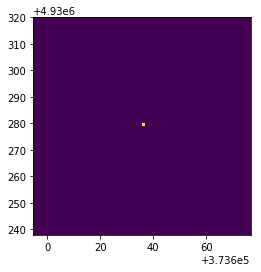

In [16]:
heatMapArea = np.ones((tiffYSize, tiffXSize)) / (tiffXSize * tiffYSize) # [y, x]
heatMapArea2 = np.ones((tiffYSize, tiffXSize)) / (tiffXSize * tiffYSize) # [y, x]


P_rx = pings[:,3]


print(calculatedDistances)
print(distanceErrors)

#ss.norm.pdf(np.linalg.norm(dx - tx), loc=modeledDistance, scale=D_std)


for y in range(tiffYSize):
    for x in range(tiffXSize):
        iDist = np.linalg.norm(pings[:,0:3] - np.array([refX+x, minY+y, 0]), axis=1)
        zscores = abs((iDist-calculatedDistances)/stdDistances)
        print(iDist-calculatedDistances)
        inds = np.round(zscores, decimals=1)
        inds2 = np.round(zscores, decimals=2)
        inds2 = (inds2*100)%10
        
        for i in range(len(inds)):
            if(inds[i] > 4):
                heatMapArea2[y, x] *= 0
            else:
                ind2 = int(inds2[i])
                heatMapArea2[y, x] *= (lookup[inds[i]][ind2] / stdDistances) 
        #heatMapArea[y, x] = np.prod(ptest)
        
        for i in range(len(pings)):
            heatMapArea[y, x] *= p_d_update(iDist[i], calculatedDistances[i], stdDistances)

plt.imshow(heatMapArea, extent=[refX,maxX,minY,refY], origin='lower')


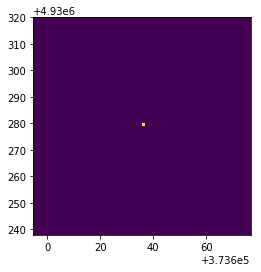

In [47]:
plt.imshow(heatMapArea2, extent=[refX,maxX,minY,refY], origin='lower')

TypeError: 'int' object is not subscriptable

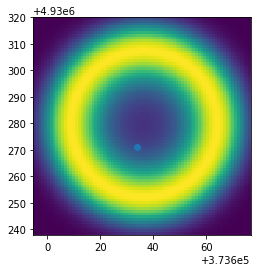

In [15]:
plt.imshow(heatMapArea, extent=[refX,maxX,minY,refY], origin='lower')
for pingNum in range(len(pings)):
    plt.scatter(pings[pingNum,0], pings[pingNum,1])
    nominalDistance = RSSItoDistance(P_rx[pingNum], P_tx, n_tx, alt=pings[pingNum,2])
    circ = Circle((pings[pingNum,0], pings[pingNum,1]), nominalDistance, fill=False, color='r')
    plt.gca().add_patch(circ)
plt.scatter(l_tx[0], l_tx[1])
plt.colorbar()

TypeError: You must first set_array for mappable

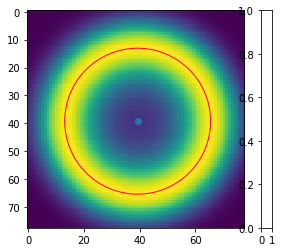

In [14]:
P_rx = 28
P_tx = 60
L_sigma = 5
n_tx = 2
alt = 30
nominalDistance = RSSItoDistance(P_rx, P_tx, n_tx, alt)
rx_location = np.array([nominalDistance * 1.5, nominalDistance * 1.5, 30])
heatMapArea = np.zeros((int(nominalDistance * 3), int(nominalDistance * 3)))
for x in range(int(nominalDistance * 3)):
    for y in range(int(nominalDistance * 3)):
        heatMapArea[y, x] = p_d(np.array([x, y, 0]), rx_location, n_tx, P_rx, P_tx, L_sigma)
plt.imshow(heatMapArea)
plt.scatter(rx_location[0], rx_location[1])
circ = Circle((rx_location[0], rx_location[1]), nominalDistance, fill=False, color='r')
plt.gca().add_patch(circ)
plt.colorbar()
plt.imshow(heatMapArea)

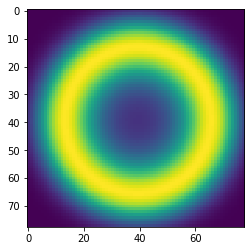

In [48]:
stdDistances

0.04987428112553065